In [1]:
# Import necessary libraries
import random
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned data from CSV
input_path = "world_bank_data_clean.csv"
world_bank_data = pd.read_csv(input_path)

In [3]:
# Data pre-processing for GDP-Level prediction MLP 
# Columns to average (everything except 'country', 'date and 'year')
cols_to_avg = [col for col in world_bank_data.columns 
               if col not in ['country', 'date', 'year']]

# Group by country and calculate mean for all other columns
mlp_data = (
    world_bank_data
        .groupby('country', as_index=False)[cols_to_avg]
        .mean()
)

# Log-transform the average GDP per capita
# (add a tiny epsilon in case of any zeros)
eps = 1e-9
mlp_data['log_GDPpc_2017$'] = np.log(mlp_data['GDPpc_2017$'] + eps)

# Quartile binning on log-GDP and 4. assign labels
mlp_data['GDPpc_label'] = pd.qcut(
    mlp_data['log_GDPpc_2017$'],
    q=4,  # quartiles
    labels=['under-developed', 'developing', 'emerging', 'developed']
)

# Drop column 'country', 'GDPpc_2017$' and 'log_GDPpc_2017$''
mlp_data = mlp_data.drop(columns=['country', 'GDPpc_2017$', 'log_GDPpc_2017$'])

# Prepare data
df = mlp_data.copy()

# Target and features
target_col = "GDPpc_label"

# Exclude target
feature_cols = [
    col for col in df.columns
    if col not in [target_col]
]

X = df[feature_cols].values.astype(np.float32)
y_labels = df[target_col].values

In [4]:
# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y_labels).astype(np.int64)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
num_classes = len(le.classes_)

# PyTorch Dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=32, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# Training / evaluation helpers 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Using device:", device)

def train_one_model(
    X_train_fold, y_train_fold,
    X_val_fold, y_val_fold,
    input_dim, num_classes,
    lr=1e-3,
    num_epochs=300,
    batch_size=32,
    weight_decay=5e-4,
    patience=30,
    min_delta=1e-5,
    log_interval=25
):
    train_ds = TabularDataset(X_train_fold, y_train_fold)
    val_ds   = TabularDataset(X_val_fold,   y_val_fold)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dim=32).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float("inf")
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # TRAIN
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = epoch_loss / total
        train_acc = correct / total

        # VALIDATION (compute val loss + val acc)
        model.eval()
        val_loss_sum = 0.0
        correct_v = 0
        total_v = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss_v = criterion(logits, yb)

                val_loss_sum += loss_v.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct_v += (preds == yb).sum().item()
                total_v += yb.size(0)

        val_loss = val_loss_sum / total_v
        val_acc  = correct_v / total_v

        # early stopping check on VAL LOSS (lower is better)
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch + 1) % log_interval == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} "
                f"- train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
                f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}"
            )

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (val_loss didn't improve by > {min_delta} for {patience} epochs)")
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return best_val_loss, model

Using device: cuda


In [7]:
# Cross Validation
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
candidate_lrs = [0.01, 0.005, 0.001, 0.0005]

lr_to_loss = {}

for lr in candidate_lrs:
    fold_losses = []
    print(f"\nEvaluating learning rate = {lr}")

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
        X_train_fold = X_train_scaled[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold   = X_train_scaled[val_idx]
        y_val_fold   = y_train[val_idx]

        best_val_loss, _ = train_one_model(
            X_train_fold, y_train_fold,
            X_val_fold,   y_val_fold,
            input_dim=input_dim,
            num_classes=num_classes,
            lr=lr,
            num_epochs=100,
            batch_size=32,
            patience=25,
            min_delta=1e-3,
            log_interval=50
        )

        fold_losses.append(best_val_loss)
        print(f"  Fold {fold_idx+1}: best_val_loss = {best_val_loss:.4f}")

    mean_loss = np.mean(fold_losses)
    lr_to_loss[lr] = mean_loss
    print(f"Mean CV best val loss for lr={lr}: {mean_loss:.4f}")

best_lr = min(lr_to_loss, key=lr_to_loss.get)
print("\nBest learning rate based on CV:", best_lr, "with mean loss =", lr_to_loss[best_lr])


Evaluating learning rate = 0.01
Epoch 1/100 - train_loss: 1.3922, train_acc: 0.2727, val_loss: 1.3044, val_acc: 0.4783
Early stopping at epoch 32 (val_loss didn't improve by > 0.001 for 25 epochs)
  Fold 1: best_val_loss = 0.9698
Epoch 1/100 - train_loss: 1.3781, train_acc: 0.3008, val_loss: 1.2742, val_acc: 0.4091
Epoch 50/100 - train_loss: 0.7225, train_acc: 0.7594, val_loss: 1.0413, val_acc: 0.5909
Early stopping at epoch 59 (val_loss didn't improve by > 0.001 for 25 epochs)
  Fold 2: best_val_loss = 0.9408
Epoch 1/100 - train_loss: 1.3816, train_acc: 0.3308, val_loss: 1.3157, val_acc: 0.5000
Epoch 50/100 - train_loss: 0.8067, train_acc: 0.7293, val_loss: 1.0089, val_acc: 0.6818
Early stopping at epoch 72 (val_loss didn't improve by > 0.001 for 25 epochs)
  Fold 3: best_val_loss = 0.8336
Epoch 1/100 - train_loss: 1.3741, train_acc: 0.3233, val_loss: 1.3296, val_acc: 0.4545
Early stopping at epoch 30 (val_loss didn't improve by > 0.001 for 25 epochs)
  Fold 4: best_val_loss = 1.1897

In [8]:
# Final training on full train set (scaled)
train_ds = TabularDataset(X_train_scaled, y_train)
test_ds  = TabularDataset(X_test_scaled,  y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

final_model = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dim=32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=5e-4)

train_losses = []
train_accs = []

num_epochs = 300
for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = final_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = epoch_loss / total
    train_acc = correct / total
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    if (epoch + 1) % 15 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {train_loss:.4f}, acc: {train_acc:.4f}")

Epoch 15/300 - loss: 0.8998, acc: 0.6452
Epoch 30/300 - loss: 0.7558, acc: 0.7355
Epoch 45/300 - loss: 0.7688, acc: 0.7613
Epoch 60/300 - loss: 0.6719, acc: 0.8000
Epoch 75/300 - loss: 0.6149, acc: 0.8323
Epoch 90/300 - loss: 0.5610, acc: 0.8581
Epoch 105/300 - loss: 0.6589, acc: 0.8000
Epoch 120/300 - loss: 0.5745, acc: 0.8516
Epoch 135/300 - loss: 0.6574, acc: 0.7935
Epoch 150/300 - loss: 0.5408, acc: 0.8581
Epoch 165/300 - loss: 0.5054, acc: 0.8581
Epoch 180/300 - loss: 0.5406, acc: 0.8516
Epoch 195/300 - loss: 0.5174, acc: 0.8516
Epoch 210/300 - loss: 0.6139, acc: 0.8323
Epoch 225/300 - loss: 0.5409, acc: 0.8452
Epoch 240/300 - loss: 0.5228, acc: 0.8968
Epoch 255/300 - loss: 0.5003, acc: 0.8645
Epoch 270/300 - loss: 0.4823, acc: 0.8903
Epoch 285/300 - loss: 0.5012, acc: 0.8774
Epoch 300/300 - loss: 0.5619, acc: 0.8516


In [9]:
# Evaluate on test set
final_model.eval()
correct = 0
total = 0
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = final_model(xb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

test_acc = correct / total
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

# Bootstrap evaluation:
# - We repeatedly resample the TEST set with replacement.
# - Each resample has the same size as the original test set (n = len(all_true)).
# - We compute metrics on each resample, then report mean ± std across resamples.

def bootstrap_metrics_table(all_true, all_preds, B=2000, seed=42):
    all_true = np.asarray(all_true)
    all_preds = np.asarray(all_preds)

    # Number of test samples
    n = len(all_true)
    print(f"Bootstrap sample size per resample: n = {n}")
    print(f"Number of bootstrap resamples: B = {B}")

    rng = np.random.default_rng(seed)

    # Collect metrics for each bootstrap resample
    rows = []
    for _ in range(B):
        # Sample indices WITH replacement (size n)
        idx = rng.integers(0, n, size=n)

        y_t = all_true[idx]
        y_p = all_preds[idx]

        rows.append({
            "Accuracy": accuracy_score(y_t, y_p),

            "Precision (macro)": precision_score(y_t, y_p, average="macro", zero_division=0),
            "Recall (macro)":    recall_score(y_t, y_p, average="macro", zero_division=0),
            "F1 (macro)":        f1_score(y_t, y_p, average="macro", zero_division=0),

            "Precision (weighted)": precision_score(y_t, y_p, average="weighted", zero_division=0),
            "Recall (weighted)":    recall_score(y_t, y_p, average="weighted", zero_division=0),
            "F1 (weighted)":        f1_score(y_t, y_p, average="weighted", zero_division=0),

            "Precision (micro)": precision_score(y_t, y_p, average="micro", zero_division=0),
            "Recall (micro)":    recall_score(y_t, y_p, average="micro", zero_division=0),
            "F1 (micro)":        f1_score(y_t, y_p, average="micro", zero_division=0),
        })

    df = pd.DataFrame(rows)

    # Summarize results as mean ± std across bootstrap resamples
    summary = pd.DataFrame({
        "Metric": df.columns,
        "Mean ± Std": [f"{df[c].mean():.4f} ± {df[c].std(ddof=1):.4f}" for c in df.columns],
    })

    return summary

summary = bootstrap_metrics_table(all_true, all_preds, B=2000, seed=42)
summary = summary.sort_values("Metric", ascending=True).reset_index(drop=True)
print(summary)

Bootstrap sample size per resample: n = 67
Number of bootstrap resamples: B = 2000


,Metric,Mean ± Std
0,Accuracy,0.6877 ± 0.0546
1,F1 (macro),0.6660 ± 0.0542
2,F1 (micro),0.6877 ± 0.0546
3,F1 (weighted),0.6752 ± 0.0580
4,Precision (macro),0.6729 ± 0.0582
5,Precision (micro),0.6877 ± 0.0546
6,Precision (weighted),0.6870 ± 0.0597
7,Recall (macro),0.6839 ± 0.0513
8,Recall (micro),0.6877 ± 0.0546
9,Recall (weighted),0.6877 ± 0.0546


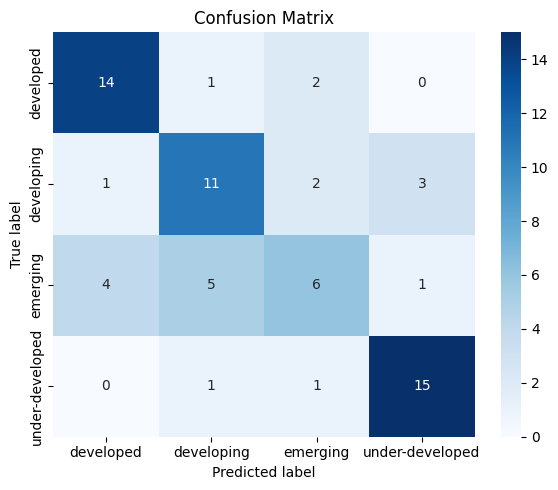

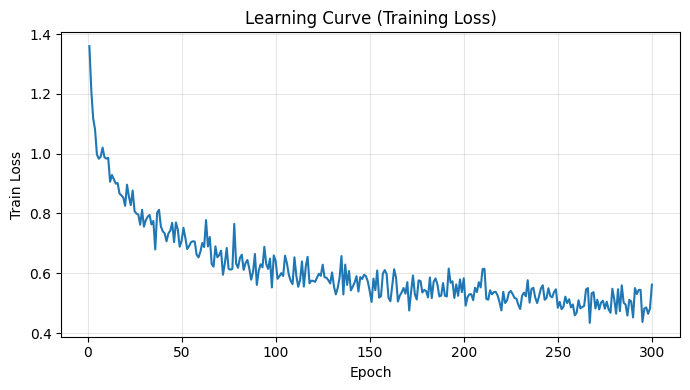

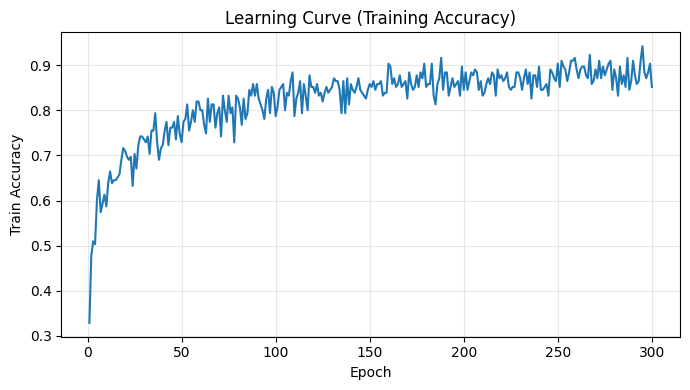

In [10]:
# Plot Confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot learning curve (train loss and train accuracy)
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Learning Curve (Training Loss)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(train_accs) + 1), train_accs)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.title("Learning Curve (Training Accuracy)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()